In [1]:
! pip install datasets transformers seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB

In [2]:
import transformers

print(transformers.__version__)

4.27.3


# GPU

In [3]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


# Fine-tuning a model on a token classification task

In [4]:
task = "pos" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "bert-base-uncased"
batch_size = 16

## Loading the dataset

In [5]:
from datasets import load_dataset, load_metric

In [6]:
dataset_name = "conll2003"
datasets = load_dataset(dataset_name)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [8]:
datasets["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [9]:
datasets["train"].features[f"pos_tags"]

Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None)

In [10]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['"',
 "''",
 '#',
 '$',
 '(',
 ')',
 ',',
 '.',
 ':',
 '``',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'NN|SYM',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'SYM',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

In [11]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [12]:
show_random_elements(datasets["train"])

,id,tokens,pos_tags,chunk_tags,ner_tags
0,13336,"[number, of, shares]","[NN, IN, NNS]","[B-NP, B-PP, B-NP]","[O, O, O]"
1,2766,"[WARSAW, 1996-08-23]","[NNP, CD]","[B-NP, I-NP]","[B-LOC, O]"
2,9040,"[Meri, 's, popularity, has, suffered, in, recent, years, ,, with, politicians, criticising, him, for, taking, too, much, power, and, acting, without, consulting, parliament, .]","[NNP, POS, NN, VBZ, VBN, IN, JJ, NNS, ,, IN, NNS, VBG, PRP, IN, VBG, RB, JJ, NN, CC, VBG, IN, NN, NN, .]","[B-NP, B-NP, I-NP, B-VP, I-VP, B-PP, B-NP, I-NP, O, B-PP, B-NP, B-VP, B-NP, B-PP, B-VP, B-NP, I-NP, I-NP, O, B-VP, B-PP, B-NP, I-NP, O]","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,42,"[FRANKFURT, 1996-08-22]","[NNP, CD]","[B-NP, I-NP]","[B-LOC, O]"
4,7911,"[Maybe, it, will, be, in, single-digits, ,, "", Wijffels, told, Reuters, .]","[RB, PRP, MD, VB, IN, NNS, ,, "", NNP, VBD, NNP, .]","[B-ADVP, B-NP, B-VP, I-VP, B-PP, B-NP, O, O, B-NP, B-VP, B-NP, O]","[O, O, O, O, O, O, O, O, B-PER, O, B-ORG, O]"
5,5713,"[Attendance, not, given, .]","[NN, RB, VBN, .]","[B-NP, O, B-VP, O]","[O, O, O, O]"
6,11768,"[Expected, Sale, Date, :, 08/26/96]","[VBN, NNP, NNP, :, CD]","[B-VP, B-NP, I-NP, O, B-NP]","[O, O, O, O, O]"
7,8023,"[-, Opposition, leader, Alfred, Sant, on, steep, rise, in, taxes, over, 10, years, .]","[:, NN, NN, NNP, NNP, IN, JJ, NN, IN, NNS, IN, CD, NNS, .]","[O, B-NP, I-NP, I-NP, I-NP, B-PP, B-NP, I-NP, B-PP, B-NP, B-PP, B-NP, I-NP, O]","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O]"
8,7442,"[MANAGUA, ,, Nicaragua, 1996-08-26]","[NNP, ,, NNP, CD]","[B-NP, O, B-NP, I-NP]","[B-LOC, O, B-LOC, O]"
9,3599,"[out, ,, W., Khan, 52, ;, R., Illingworth, 4-54, ,, S., Lampitt, 4-90, ), .]","[RP, ,, NNP, NNP, CD, :, NNP, NNP, CD, ,, NNP, NNP, CD, ), .]","[B-PRT, O, B-NP, I-NP, I-NP, O, B-NP, I-NP, I-NP, O, B-NP, I-NP, I-NP, O, O]","[O, O, B-PER, I-PER, O, O, B-PER, I-PER, O, O, B-PER, I-PER, O, O, O]"


## Preprocessing the data

In [13]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [15]:
tokenizer("Hello, this is one sentence!")

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 3975, 2046, 2616, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
example = datasets["train"][4]
print(example["tokens"])

['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']


In [18]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', 'germany', "'", 's', 'representative', 'to', 'the', 'european', 'union', "'", 's', 'veterinary', 'committee', 'werner', 'z', '##wing', '##mann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheep', '##me', '##at', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.', '[SEP]']


In [19]:
len(example[f"{task}_tags"]), len(tokenized_input["input_ids"])

(31, 39)

In [20]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, None]


In [21]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

39 39


In [22]:
label_all_tokens = True

In [23]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [24]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102], [101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102], [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1

In [25]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

## Fine-tuning the model

In [26]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [27]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

In [28]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
metric = load_metric("seqeval")

<ipython-input-29-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [30]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

{'B': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'BD': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'D': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'J': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 3},
 'JR': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'N': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 7},
 'NP': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 5},
 'NS': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'OS': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'T': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [31]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [33]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.566000,0.321785,0.907883,0.915395,0.911624,0.924413
2,0.199500,0.299040,0.917873,0.921436,0.919651,0.930354
3,0.136100,0.283059,0.918302,0.924251,0.921267,0.932054


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: : seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: . seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: CD

TrainOutput(global_step=2634, training_loss=0.2564609646344601, metrics={'train_runtime': 519.0614, 'train_samples_per_second': 81.152, 'train_steps_per_second': 5.075, 'total_flos': 1021667324143800.0, 'train_loss': 0.2564609646344601, 'epoch': 3.0})

In [34]:
trainer.evaluate()

{'eval_loss': 0.2830590307712555,
 'eval_precision': 0.9183019140832168,
 'eval_recall': 0.9242508795341502,
 'eval_f1': 0.9212667932331282,
 'eval_accuracy': 0.9320539501485376,
 'eval_runtime': 13.1417,
 'eval_samples_per_second': 247.304,
 'eval_steps_per_second': 15.523,
 'epoch': 3.0}

In [35]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{"'": {'precision': 1.0,
  'recall': 0.5454545454545454,
  'f1': 0.7058823529411764,
  'number': 11},
 'B': {'precision': 0.9082020640956002,
  'recall': 0.8767697954902989,
  'f1': 0.8922091782283885,
  'number': 1907},
 'BD': {'precision': 0.9395002192021044,
  'recall': 0.9635791366906474,
  'f1': 0.951387347391787,
  'number': 2224},
 'BG': {'precision': 0.896358543417367,
  'recall': 0.9155937052932761,
  'f1': 0.9058740268931352,
  'number': 699},
 'BN': {'precision': 0.8946759259259259,
  'recall': 0.8329741379310345,
  'f1': 0.8627232142857143,
  'number': 928},
 'BP': {'precision': 0.8579088471849866,
  'recall': 0.8767123287671232,
  'f1': 0.8672086720867208,
  'number': 365},
 'BR': {'precision': 0.7555555555555555,
  'recall': 0.6415094339622641,
  'f1': 0.6938775510204082,
  'number': 53},
 'BS': {'precision': 0.7777777777777778,
  'recall': 0.7777777777777778,
  'f1': 0.7777777777777778,
  'number': 18},
 'BZ': {'precision': 0.9182879377431906,
  'recall': 0.9273084479371

In [36]:
trainer.save_model('{model_name}-finetuned-{task}')

In [37]:

from scipy.stats import ttest_ind
import numpy as np
# import matplotlib.pyplot as plt
# import ipdb
class NeuronAnalyzer: 
    
    '''
    Take cls embeddings from pretrained and finetuned models and perform statistical analysis on the neurons.
    '''
    
    def __init__(self, pretained_activations, finetuned_activations) -> None:
        self.pretained_activations = pretained_activations
        self.finetuned_activations = finetuned_activations
        
        self.neuron_rankings = None
        
    
    def plot_neuron_histograms(self, top_k=10, save_path="./figs"):
        neuron_indices = self.rank_neuron()[:top_k]
        for top_i, neuron_idx in enumerate(neuron_indices): 
            
            plt.hist(self.pretained_activations[:, neuron_idx], bins=20, alpha=0.5, label="pretrained", color='blue')
            plt.hist(self.finetuned_activations[:, neuron_idx], bins=20, alpha=0.5, label="finetuned", color='red')
            plt.title('Histogram of activations for neuron {}'.format(neuron_idx))
            plt.xlabel('Actviations')
            plt.ylabel('Frequency')
            plt.legend(loc='upper right')
            plt.savefig(f"{save_path}/histograms_top{top_i}_neuron_{neuron_idx}.png")
            plt.clf()

    # def compute_spearman_stat(self):
    #     self.neuron_rankings = []
    #     self._rank_neuron()
    
    def rank_neuron(self, method="t_stat"): 
        if method == "t_stat":
            t_stats = self._compute_t_stat()
            # Get the indices of the sorted array in descending order
            sorted_neurons_indices = np.argsort(t_stats)[::-1]
        
        return list(sorted_neurons_indices)
        
    def _compute_t_stat(self, alpha=0.05):
        # num_of_neurons = self.pretained_activations.shape[1]
        t_stats, p_vals = ttest_ind(self.pretained_activations, self.finetuned_activations, axis=0)
        significant_neurons = np.where(p_vals < alpha)[0]
        # ipdb.set_trace()
        return t_stats[significant_neurons]

In [38]:

class NeuronExtractor: 
    
    '''
    Take a trained model (either pretrained or finetuned) and N test sentences and return the cls embedding of shape (N, d_model). 
    '''
    
    def __init__(self, model, tokenizer, is_split_into_words=False) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.is_split_into_words = is_split_into_words
        self.model.to(self.device)
    
    # todo: batched inference, due to the limited memory of the GPU
    @torch.no_grad()
    def extract_cls(self, sentences):
        input_ids = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", is_split_into_words=self.is_split_into_words).to(self.device)
        outputs = self.model(**input_ids)
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        return cls_embedding
    
    @torch.no_grad()
    def extract_layer(self, sentences, layer_num):
        input_ids = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", is_split_into_words=self.is_split_into_words).to(self.device)
        outputs = self.model(**input_ids)
        embedding = outputs.hidden_states[layer_num-1].detach().cpu().numpy()
        return embedding

In [42]:
import torch
import transformers
from transformers import AutoModel, AutoTokenizer
# dataset_name1 = "ptb_text_only"
# dataset1 = load_dataset(dataset_name1, split="test").select(range(500))
layer_embs_pretrained = []

# Load the pretrained model
model_checkpoint = "bert-base-uncased"
model_pretrained = AutoModel.from_pretrained(model_checkpoint, output_hidden_states=True)
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_checkpoint)
cls_emb_pretrained = NeuronExtractor(model_pretrained, tokenizer_pretrained, is_split_into_words=True).extract_cls(datasets["test"]["tokens"][:200])
for layer_num in range(1,13):

  layer_emb_pretrained = NeuronExtractor(model_pretrained, tokenizer_pretrained, is_split_into_words=True).extract_layer(datasets["test"]["tokens"][:200], layer_num)
  layer_embs_pretrained.append(layer_emb_pretrained)
# cls_emb_pretrained = NeuronExtractor(model_pretrained, tokenizer_pretrained).extract_cls(dataset["sentence"])
# layer1_emb_pretrained = NeuronExtractor(model_pretrained, tokenizer_pretrained).extract_layer(dataset1["sentence"], 2)


In [43]:

# Load the finetuned model
model_checkpoint_finetuned = "{model_name}-finetuned-{task}"
model_finetuned = AutoModel.from_pretrained(model_checkpoint_finetuned, output_hidden_states=True)
tokenizer_finetuned = AutoTokenizer.from_pretrained(model_checkpoint)
layer_embs_finetuned = []
cls_emb_finetuned = NeuronExtractor(model_finetuned, tokenizer_finetuned, is_split_into_words=True).extract_cls(datasets["test"]["tokens"][:200])
for layer_num in range(1,13):

  layer_emb_finetuned = NeuronExtractor(model_finetuned, tokenizer_finetuned, is_split_into_words=True).extract_layer(datasets["test"]["tokens"][:200], layer_num)
  layer_embs_finetuned.append(layer_emb_finetuned)
# cls_emb_finetuned = NeuronExtractor(model_finetuned, tokenizer_finetuned).extract_cls(dataset1["sentence"])
# layer1_emb_finetuned = NeuronExtractor(model_finetuned, tokenizer_finetuned).extract_layer(dataset1["sentence"], 2)

Some weights of the model checkpoint at {model_name}-finetuned-{task} were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at {model_name}-finetuned-{task} and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
print(layer_embs_pretrained[1].shape)
# print(layer1_emb_finetuned.shape)

(200, 122, 768)


In [47]:
for i in range(len(layer_embs_pretrained)):
  layer_embs_pretrained[i] = np.mean(layer_embs_pretrained[i], axis = 0)
  layer_embs_pretrained[i] = np.mean(layer_embs_pretrained[i], axis = 0)
  print(layer_embs_pretrained[i].shape)

(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)


In [48]:
for i in range(len(layer_embs_finetuned)):
  layer_embs_finetuned[i] = np.mean(layer_embs_finetuned[i], axis = 0)
  layer_embs_finetuned[i] = np.mean(layer_embs_finetuned[i], axis = 0)
  print(layer_embs_finetuned[i].shape)

(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)


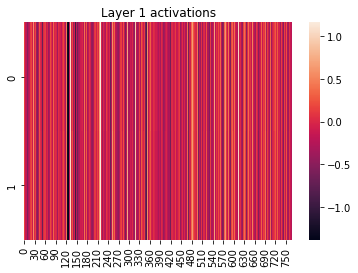

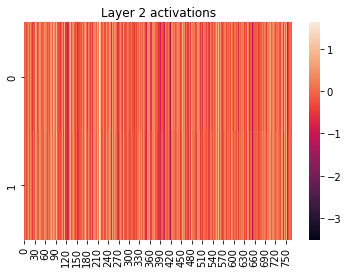

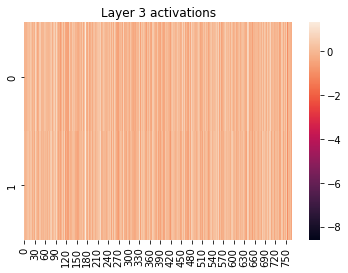

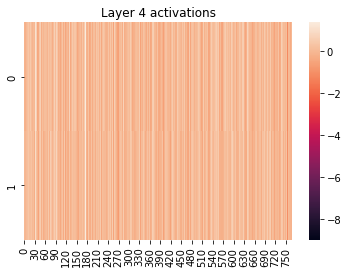

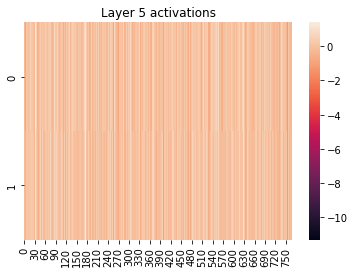

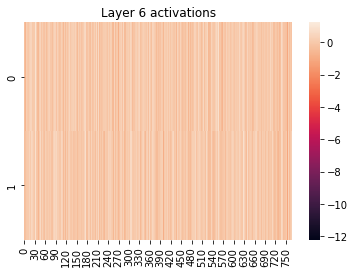

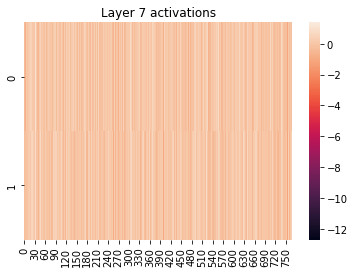

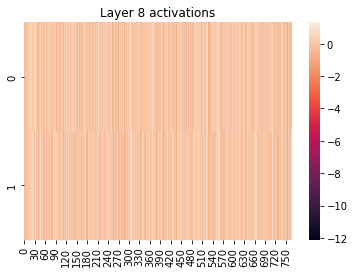

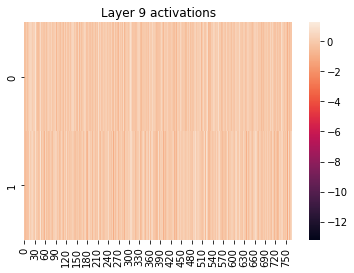

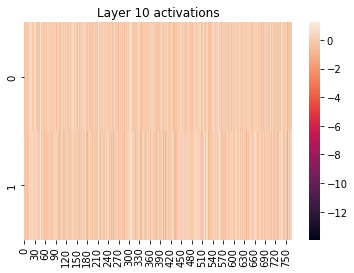

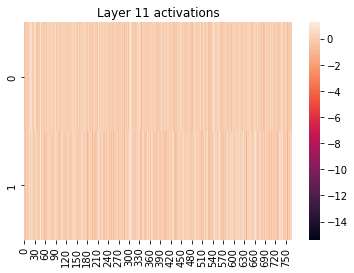

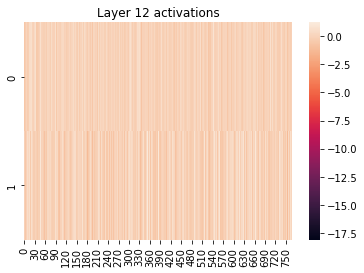

In [51]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
for i in range(len(layer_embs_finetuned)):
  lis = [layer_embs_pretrained[i], layer_embs_finetuned[i]]
  # print(data.shape)
  data = pd.DataFrame(lis)

  # Create the heatmap using seaborn
  sns.heatmap(data)

  # Show the plot
  plt.title("Layer " + str(i+1) + " activations")
  plt.show()

# sns.heatmap(cls_emb_finetuned)
# plt.show()